# Shelf Space Allocation

In [164]:
using JuMP, Gurobi, CSV
using Base.Filesystem


# Load data from CSV files. Data is read into a DataFrame.
project_dir = dirname(@__DIR__) |> dirname

"""
Fields:
* product_id
* width
* height
* length
* ItemNetWeightKg
* monthly_demand
* replenishment_interval
* price
* unit_margin
* blocking_field
* min_facing
* max_facing
* max_stack
* up_down_order_cr
* block_order_cr
"""
product_data = CSV.read(joinpath(project_dir, "data", "Anonymized space allocation data for 9900-shelf.csv"))

"""
Fields:
* Module
* id
* Level
* Total_Width
* Total_Height
* Total_Length
* Product_Min_Unit_Weight
* Product_Max_Unit_Weight
"""
shelf_data = CSV.read(joinpath(project_dir, "data", "scenario_9900_shelves.csv"))

# Sets and Subsets
products = 1:size(product_data, 1)
shelves = 1:size(shelf_data, 1)

# Groups product indices by blocking_field value.
bfs = product_data.blocking_field
P_b = [collect(products)[bfs .== bf] for bf in unique(bfs)]
blocks = 1:size(P_b, 1)

# We only consider one module in this code.
# modules = 1:1

# Parameters
G_p = product_data.unit_margin
H_s = shelf_data.Total_Height
L_p = product_data.up_down_order_cr
P_ps = transpose(shelf_data.Total_Length) ./ product_data.length
D_p = product_data.monthly_demand
N_p_min = product_data.min_facing
N_p_max = product_data.max_facing
W_p = product_data.width
W_s = shelf_data.Total_Width
M_p = product_data.ItemNetWeightKg
M_s_min = shelf_data.Product_Min_Unit_Weight
M_s_max = shelf_data.Product_Max_Unit_Weight
R_p = product_data.replenishment_interval
L_s = shelf_data.Level

# Model
model = Model()

# Variables
@variable(model, s_p[products] ≥ 0)
@variable(model, e_p[products] ≥ 0)
@variable(model, n_ps[products, shelves] ≥ 0, Int)
@variable(model, o_s[shelves] ≥ 0)

# Objective
@objective(model, Min,
    sum(o_s[s] for s in shelves) +
    sum(G_p[p] * e_p[p] for p in products)
#     + sum(L_p[p] * L_s[s] * n_ps[p, s] for p in products for s in shelves)
)

# Constraints
M = [max(maximum(30 / R_p[p] * P_ps[p, s] for s in shelves) * N_p_max[p], D_p[p]) for p in products]
@variable(model, σ[products], Bin)
@constraints(model, begin
    [p = products],
    s_p[p] ≤ sum(30 / R_p[p] * P_ps[p, s] * n_ps[p, s] for s in shelves)
    [p = products],
    s_p[p] ≥ sum(30 / R_p[p] * P_ps[p, s] * n_ps[p, s] for s in shelves) - M[p] * σ[p]
    [p = products],
    s_p[p] ≤ D_p[p]
    [p = products],
    s_p[p] ≥ D_p[p] - M[p] * (1 - σ[p])
end)
@constraint(model, [p = products],
    s_p[p] + e_p[p] == D_p[p])
@constraint(model, [p = products],
    N_p_min[p] ≤ sum(n_ps[p, s] for s in shelves) ≤ N_p_max[p])
@constraint(model, [s = shelves],
    sum(W_p[p] * n_ps[p, s] for p in products) + o_s[s] == W_s[s])

# @variable(model, y_p[products], Bin)
# @constraint(model, [p = products],
#     sum(n_ps[p, s] for s in shelves) ≥ y_p[p])

# Weight constraint
# @constraint(model, [s = shelves],
#     M_s_min[s] ≤ sum(M_p[p] * n_ps[p, s] for p in products) ≤ M_s_max[s])

# Height constraint
H_p = product_data.height
@variable(model, y_ps[products, shelves], Bin)
@constraint(model, [p = products, s = shelves],
    n_ps[p, s] ≤ N_p_max[p] * y_ps[p, s])
@constraint(model, [p = products, s = shelves],
    y_ps[p, s] * H_p[p] ≤ H_s[s])

# # Block variables and constraints
# @variable(model, b_bs[blocks, shelves] ≥ 0)
# @variable(model, m_bm[blocks] ≥ 0)
# @variable(model, z_bs[blocks, shelves], Bin)
# @constraint(model, [s = shelves, b = blocks, p = P_b[b]],
#     W_p[p] * n_ps[p, s] ≤ b_bs[b, s])
# @constraint(model, [s = shelves],
#     sum(b_bs[b, s] for b in blocks) ≤ W_s[s])
# # ---
# @constraint(model, [s = shelves, b = blocks, p = P_b[b]],
#     W_p[p] * n_ps[p, s] ≤ b_bs[b, s])
# @constraint(model, [s = shelves],
#     sum(b_bs[b, s] for b in blocks) ≤ W_s[s])
# # ---
# @constraint(model, [b = blocks, s = shelves],
#     b_bs[b, s] ≥ m_bm[b] - W_s[s] * (1 - z_bs[b, s]))
# @constraint(model, [b = blocks, s = shelves],
#     b_bs[b, s] ≤ m_bm[b] + W_s[s] * (1 - z_bs[b, s]))
# @constraint(model, [b = blocks, s = shelves],
#     b_bs[b, s] ≤ W_s[s] * z_bs[b, s])
# # ---
# @variable(model, z_bs_f[blocks, shelves], Bin)
# @variable(model, z_bs_l[blocks, shelves], Bin)
# @constraint(model, [b = blocks, s = 1:length(shelves)-1],
#     z_bs_f[b, s+1] + z_bs[b, s] == z_bs[b, s+1] + z_bs_l[b, s])
# @constraint(model, [b = blocks],
#     sum(z_bs_f[b, s] for s in shelves) ≤ 1)
# @constraint(model, [b = blocks],
#     sum(z_bs_l[b, s] for s in shelves) ≤ 1)
# @constraint(model, [b = blocks],
#     z_bs_f[b, 1] == z_bs[b, 1])
# @constraint(model, [b = blocks],
#     z_bs_l[b, end] == z_bs[b, end])
# # ---
# @constraint(model, [b = blocks, s = shelves],
#     sum(n_ps[p, s] for p in products) ≥ z_bs[b, s])
# @constraint(model, [b = blocks, s = shelves, p = P_b[b]],
#     n_ps[p, s] ≤ N_p_max[p] * z_bs[b, s])
# # ---
# @variable(model, x_bs[blocks, shelves] ≥ 0)
# @variable(model, x_bm[blocks] ≥ 0)
# @variable(model, w_bb[blocks, blocks], Bin)
# @constraint(model, [b = blocks, b′ = blocks, s = shelves],
#     x_bs[b, s] ≥ x_bs[b′, s] + b_bs[b, s] - W_s[s] * (1 - w_bb[b, b′]))
# @constraint(model, [b = blocks, b′ = blocks, s = shelves],
#     x_bs[b′, s] ≥ x_bs[b, s] + b_bs[b, s] - W_s[s] * w_bb[b′, b])
# @constraint(model, [b = blocks, s = shelves],
#     x_bm[b] ≥ x_bs[b, s] - W_s[s] * (1 - z_bs[b, s]))
# @constraint(model, [b = blocks, s = shelves],
#     x_bm[b] ≤ x_bs[b, s] + W_s[s] * (1 - z_bs[b, s]))
# @constraint(model, [b = blocks, s = shelves],
#     x_bs[b, s] ≤ W_s[s] * z_bs[b, s])
# # ---
# @variable(model, v_bm[blocks], Bin)
# @constraint(model, [b = blocks, s = shelves, p = P_b[b]],
#     n_ps[p, s] ≤ N_p_max[p] * v_bm[b])
# @constraint(model, [b = blocks],
#     sum(v_bm[b]) ≤ 1)
;

In [165]:
# Optimize
optimize!(model, with_optimizer(Gurobi.Optimizer))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 4427 rows, 3985 columns and 12825 nonzeros
Variable types: 670 continuous, 3315 integer (1768 binary)
Coefficient statistics:
  Matrix range     [9e-01, 4e+02]
  Objective range  [5e-01, 4e+01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e-01, 1e+04]
Found heuristic solution: objective 75533.304700
Presolve removed 3740 rows and 2434 columns
Presolve time: 0.01s
Presolved: 687 rows, 1551 columns, 5429 nonzeros
Variable types: 36 continuous, 1515 integer (274 binary)

Root relaxation: objective 3.462512e+02, 332 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  346.25121    0   61 75533.3047  346.25121   100%     -    0s
H    0     0                     589.1023027  346.25121  41.2%     -    0s
H    0     0                 

In [166]:
sum(value.(o_s)), sum(G_p[p] * value(e_p[p]) for p in products)

(0.0, 346.25120844039037)

TODO: plot all different optimal solutions

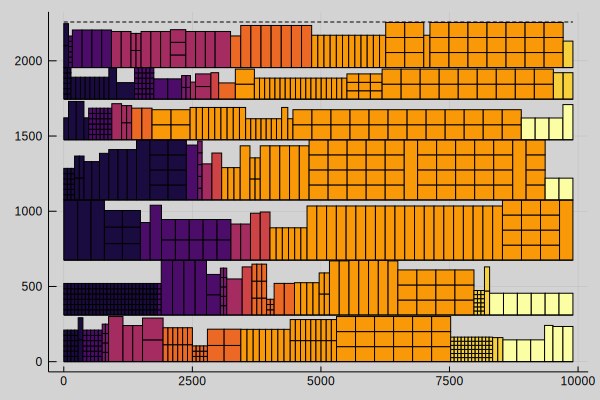

In [161]:
using Plots

plt = plot(legend=:none, background=:lightgray)

y_s = vcat([0], cumsum(H_s))
rect(x, y, w, h) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
H_p = product_data.height
block_colors = cgrad(:inferno)
n_ps2 = value.(n_ps)

for s in shelves
    x = 0
    for b in blocks
        for p in P_b[b]
            stack = max(min(div(H_s[s], H_p[p]), product_data.max_stack[p]), 1)
            for i in 1:n_ps2[p, s]
                y = 0
                for j in 1:stack
                    plot!(plt, rect(x, y_s[s]+y, W_p[p], H_p[p]), 
                          color=block_colors[b/length(blocks)], 
#                           linecolor=[:blue, :red][p%2+1]
                    )
                    y += H_p[p]
                end
                x += W_p[p]
            end
        end
    end
end

# Draw a line from (0, y[s]) to (W_s[s], y[s])
for s in shelves
    plot!(plt, [0, W_s[s]], [y_s[s], y_s[s]],
          color = :black, label="s_$s")
end
plot!(plt, [0, W_s[end]], [y_s[end], y_s[end]],
      color = :black, linestyle = :dash)

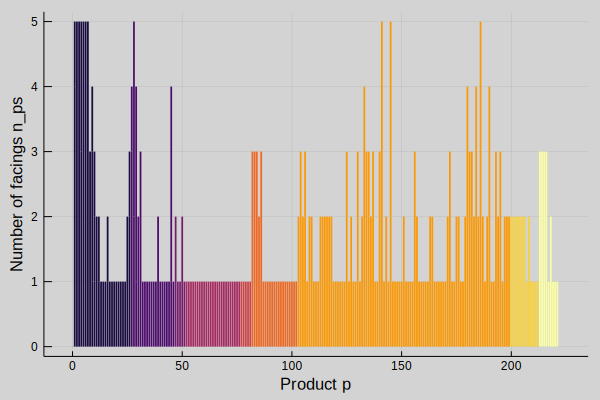

In [159]:
using StatsPlots
groupedbar(
    Matrix(value.(n_ps)), 
    bar_position=:stack, 
#     labels=["s$s" for s in shelves],
    xlabel="Product p",
    ylabel="Number of facings n_ps",
    color=[cgrad(:inferno)[b/length(blocks)] for b in blocks for _ in P_b[b]],
    linewidth=0,
    legend=:none,
    background=:lightgray
)

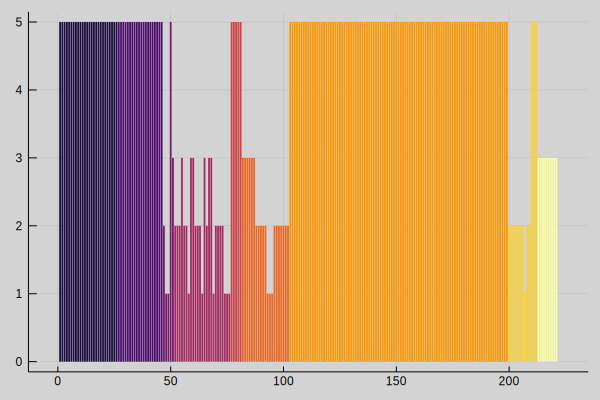

In [155]:
# Max facings
bar(N_p_max, 
    linewidth=0, 
    color=[cgrad(:inferno)[b/length(blocks)] for b in blocks for _ in P_b[b]],
    background=:lightgray,
    legend=:none)